# Deep Q-Learning with a DOOM environment

This notebook was created thanks to a course on Deep Reinforcement Learning created by Thomas Simonini. You can find the syllabus here: https://simoninithomas.github.io/Deep_reinforcement_learning_Course/

**Deep Q-Learning** is a way to apply the concepts of Q-Learning to environments that have millions of different states and therefore are unsuitable to be tackled by an agent using a Q-Table. Therefore we will train a neural network that will try to **approximate the Q-values** for each possible action in the given environment.

The objective of this notebook is to train an agent through a **Neural network** to play a DOOM environment with the following rules:

- A monster is spawned randomly somewhere along the opposite wall.
- Player can only go left/right and shoot.
- 1 hit is enough to kill the monster.

- Episode finishes when monster is killed or on timeout (300).

The **rewards** are as follows:
- +101 for killing the monster
- -5 for missing
- Episode finishes and monster is still alive = -1


Since we're dealing with image frames from a video game we will use a **Convolutional Neural Network (CNN)** given their performance and efficiency in dealing with images. This an example frame from the DOOM environment that we will be using:

<img src="doom_frame.png" width="400">

To decrease the processing load and duration of the training I will first pre-process the image. First of all, the image can be converted to **grayscale** since there's no need for color to recognize the monster from the rest of the frame. This already saves a lot of time given that we're dealing with a **single channel** and not 3 (RGB).

Then the roof can be cut out of the frame since the monster cannot appear on that part of the frame. There is also no need to use the full resolution of the environment therefore the image can be **downscaled to a lower resolution**.

An important point to make is that the neural the network will not be trained with one frame at a time but with **4 stacked frames**. This is necessary so that the model can learn in which **direction** is the enemy moving, because a single frame does not convey that kind of information.


# 1. Importing dependencies

In [1]:
import keras as ks      # Deep Learning library
import numpy as np           # Matrices handling
from vizdoom import *        # Doom Environment

import random                # Random number generation
import time                  # Used only for pause
from skimage import transform # Image pre-processing

from collections import deque # List-like data structure with faster insert/pop operations
import matplotlib.pyplot as plt # Plotting metrics

import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/emanuele/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/emanuele/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/emanuele/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/emanuele/.local/lib/python3.6/site-packages/tensorflo

# 2. Creating and testing environment

The DOOM environment needs:
- a **config file** to configure the various options (frame size, render options, possible actions, etc.)
- a **scenario file** to load the correct scenario (in this case the most basic one)

In [2]:
def create_environment():
    '''
    Creates a DOOM environment with a basic scenario and config.
    
    Input: None
    
    Output: 
        game: the initialized game environment
        possible_actions: the list of possible actions in the environment'''
    
    game = DoomGame()
    
    # Load config and scenario
    game.load_config('./doom_files/basic.cfg')
    game.set_doom_scenario_path('./doom_files/basic.wad')
    
    # Initializing game
    game.init()
    
    # Three possible actions
    left = [1, 0, 0]
    right = [0, 1, 0]
    shoot = [0, 0, 1]
    possible_actions = [left, right, shoot]
    
    return game, possible_actions


def test_environment():
    # Creating environment and obtaining list of actions
    game, actions = create_environment()
    
    # Testing for 5 episodes
    episodes = 5
    
    for ep in range(episodes):
        # Reset environment to new episode
        game.new_episode()
        
        while not game.is_episode_finished():
            state = game.get_state()
            # Matrix of pixel values of current screen
            img = state.screen_buffer
            # Choosing action at random and
            action = random.choice(actions)
            # Executing action
            game.make_action(action)
            time.sleep(0.05)
        print(f"Result of episode {ep}: {game.get_total_reward()}")
        time.sleep(2)
    game.close()
            

In [ ]:
# Run only to test the environment

# test_environment()

# 3. Image preprocessing

The preprocessing steps that will be applied to the frames are the following:
- Grayscale the images (already done by setting screen_format = GRAY8 in the .cfg file)
- Crop the screen removing the roof since it's not relevant and extreme right and left of the screen since the monster cannot move there
- Normalizing the values so that they all have a value between 0 and 1
- We then resize the frame to make it smaller given that we don't need the full resolution

In [9]:
def preprocess_frame(frame):
    # Removing room and left-right extremes
    crop_frame = frame[30:-10, 30:-30]
    
    # Normalizing pixel values
    normalized_frame = crop_frame/255.0
    
    # Resizing
    preprocessed_frame = transform.resize(normalized_frame, [84, 84])
    
    return preprocessed_frame

In [4]:
# Obtaining normal and preprocessed frame from game environment
game = create_environment()[0]
state = game.get_state()
original_frame = state.screen_buffer
preprocessed_frame = preprocess_frame(original_frame)
game.close()

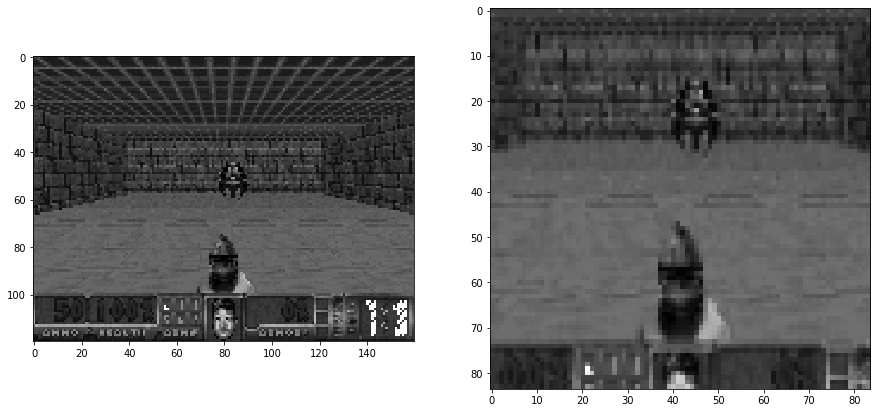

In [22]:
# Showing the two frames
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].imshow(original_frame, cmap='gray')
ax[1].imshow(preprocessed_frame, cmap='gray')
plt.show()